In [126]:
# Import my functions from repo
from utils.make_dataloader import get_dataloader
from utils.no_da_training_test_loops import training_loop, test_loop
from utils.da_training_test_loops import dann_training_loop, dann_test_loop
# Import my network objects form repo
from networks.cnn_no_da import NeuralNetworkNoDA
from networks.dann import DANN

# To look at network architecture, how I made the training/val/test loops, and the dataloader functions, they are in the repo under the above directories

In [127]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
import time
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
print('Is gpu available - ', torch.cuda.is_available())

Is gpu available -  True


# Training a baseline model without domain adaptation, just on source data
**We can use this to compare testing accuracy on source and target data afterwards**

### There are a couple steps I took that aren't shown here, that can be found in the repo:
**First, I edited the dataframe csv files to make them easier to use. This can be found in the edit_csv_files directory**  
**Then, I used data augmentation in the dataloader. This included downsizing the images to 64x64, randomly rotating them 90 degrees, randomly flipping them horizontaly, then putting them into pytorch tensor dataformat. These can be found under the utils directory, in the make_dataloader python file**

In [128]:
# Load in source and target data, and set batch size
root_dir = 'C:/Users/paxso/galclass_da/gal_img_full/gal_img_full/'
source_csv_file = root_dir+"gal_list.csv" # Dataframe with sdss images
target_csv_file = root_dir + 'hsc_dataframe.csv' # Dataframe with hsc images
batch_size = 32 # Found through testing that this is the best
# Load source data
domain = 'source'
source_dataloaders, source_datasets = get_dataloader(source_csv_file, root_dir, domain, batch_size, train_size=.90, 
                                                     val_size=.025, test_size=.075) 
                                                    # Because we used a seed based generator and set the seed as a constant
                                                    # we should always get the same images in train/test/split

source_train_dataloader, source_val_dataloader, source_test_dataloader = source_dataloaders
source_train_dataset, source_val_dataset, source_test_dataset = source_datasets
# Load target data
domain = 'target'
target_dataloaders, target_datasets = get_dataloader(target_csv_file, root_dir, 'target', batch_size, train_size=.90, 
                                                     val_size=.025, test_size=.075)

target_train_dataset, target_val_dataset, target_test_dataset = target_datasets

In [145]:
# Let's visualize the dataset
# Define data visualization function
def visualize_data(dataset):
    '''
    visualizes 16 random images from dataset
    '''
    #get random indices
    x = np.empty(1)
    i = 1

    while i < 16:
        example_num = int(random.randrange(0, len(dataset)))
        if example_num != x[i-1]:
            x = np.append(x, [example_num])
            i += 1
        
    #plot the examples for source
    fig1=plt.figure(figsize=(8,8))

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.axis("off")
    
        example_indices = int(x[i])
    
        example_image, label = dataset[example_indices]
    
        plt.imshow(example_image.permute(1, 2, 0), aspect='auto', cmap='viridis')
        plt.title(int(label[0]))

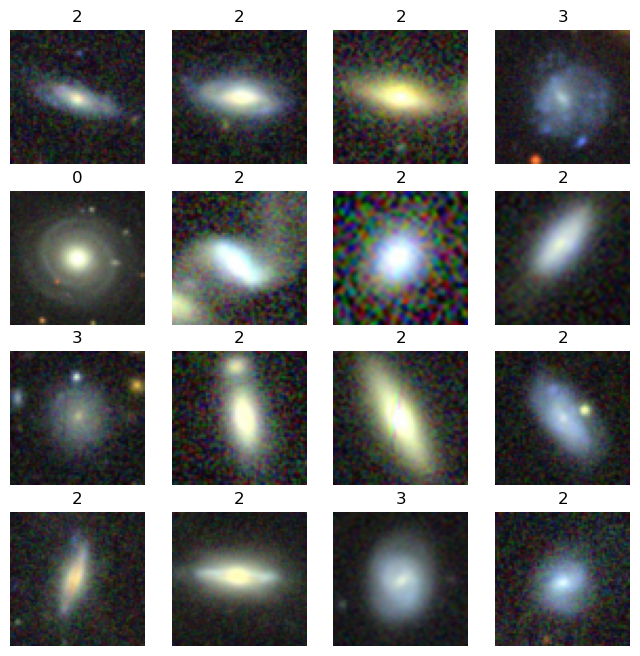

In [146]:
# Visualize source data
visualize_data(source_train_dataset)

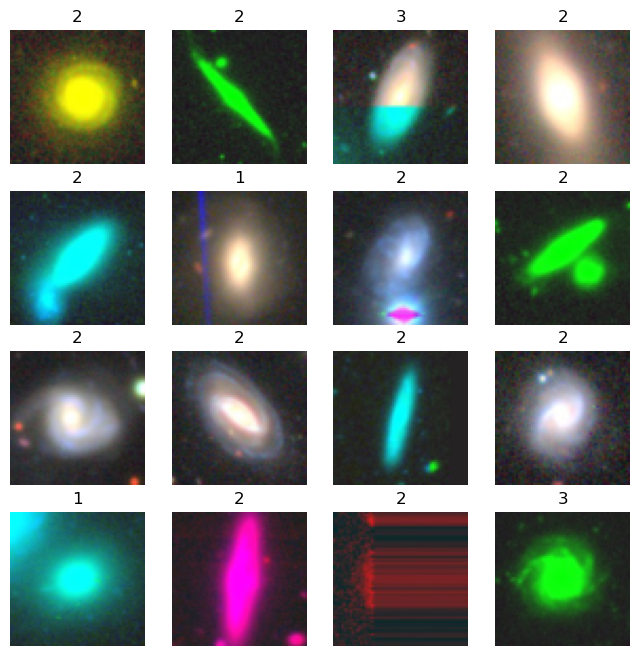

In [144]:
# Visualize target data
visualize_data(target_train_dataset)

**This shows how a lot of the target images are corrupted, or missing color paths. I tried to remove as many corrupted images as I could simply, but some remain. This makes a good challenge for the domain adaptation and mirrors real domain adaptation training situations!**

In [4]:
# Initiate no domain adaptation CNN, optimizer, loss function, and hyperparameters
no_da_model = NeuralNetworkNoDA().cuda()
no_da_epochs = 60
lr = 5.0e-4
no_da_optimizer = torch.optim.Adam(no_da_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss().cuda()

In [5]:
# Train no domain adaptation model
no_da_stats = np.zeros((no_da_epochs, 4))

for epoch in range(no_da_epochs):
    print('epoch: ', epoch)
    start_time = time.time()
    training_accuracy, training_loss, val_accuracy, val_loss = training_loop(source_train_dataloader, 
                                                                             source_val_dataloader, no_da_model, 
                                                                             no_da_optimizer, loss_fn)
    print('Stats: ', training_accuracy, training_loss, val_accuracy, val_loss)
    print('Runtime: ', time.time() - start_time)
    stats = np.array([training_accuracy, training_loss, val_accuracy, val_loss])
    no_da_stats[epoch] = stats

epoch:  0
Stats:  0.6751089162091192 1.061243021693085 0.6901939655172413 1.0516680730827923
Runtime:  77.49852252006531
epoch:  1
Stats:  0.7246135712580568 1.014189086244396 0.7308728448275862 1.0095761007276074
Runtime:  78.94800400733948
epoch:  2
Stats:  0.736586894246837 1.002791427689482 0.734375 1.003789299520953
Runtime:  76.76202273368835
epoch:  3
Stats:  0.7432039269515397 0.9966687997191697 0.7381465517241379 0.9983742355272688
Runtime:  77.2394437789917
epoch:  4
Stats:  0.7501342802578181 0.9891282827565595 0.7456896551724138 0.9949277834645633
Runtime:  77.51882696151733
epoch:  5
Stats:  0.7530063857722606 0.9868043075458165 0.748114224137931 0.9908795767817004
Runtime:  77.61189436912537
epoch:  6
Stats:  0.7576688947242779 0.9826244554504855 0.7446120689655172 0.9934002633752494
Runtime:  77.40881872177124
epoch:  7
Stats:  0.75986959894963 0.9803017009326227 0.7521551724137931 0.986879772153394
Runtime:  77.28470802307129
epoch:  8
Stats:  0.7632266053950824 0.97694

**I've saved this model under networks, "cnn_no_da_trained.pt". This can be loaded in like this:**  
model = NeuralNetworkNoDA().cuda()  
model.load_state_dict(torch.load('path/to/network/save.pt'))

In [23]:
torch.save(no_da_model.state_dict(), 'C:/Users/paxso/galclass_da/code/networks/cnn_no_da_trained.pt')

Our baseline model accuracy and loss on the source data is 0.7978151862464183 0.9431880881588234


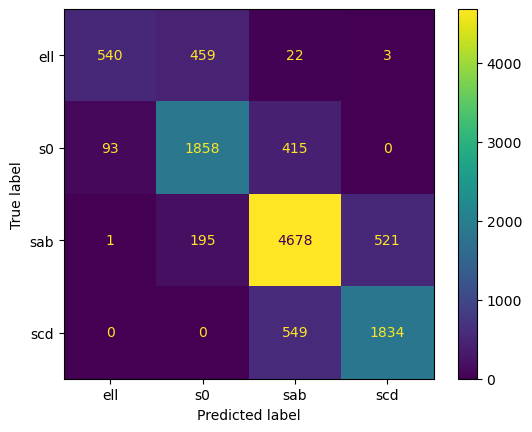

In [132]:
# Test it on source
source_test_accuracy, source_test_loss, source_test_predictions, source_test_true = test_loop(source_test_dataloader, no_da_model, loss_fn)
print('Our baseline model accuracy and loss on the source data is', source_test_accuracy, source_test_loss)

# Reformate predictions to use in confusion matrix
source_test_predictions_array = np.array([])
source_test_true_array = np.array([])
for i in range(len(source_test_predictions)):
    batch_preds = source_test_predictions[i].numpy()
    batch_true = source_test_true[i].numpy()
    source_test_predictions_array = np.append(source_test_predictions_array, batch_preds)
    source_test_true_array = np.append(source_test_true_array, batch_true)
# Plot confusion matrix    
source_test_cm = confusion_matrix(source_test_true_array, source_test_predictions_array)
source_test_cm_plot = ConfusionMatrixDisplay(source_test_cm, display_labels=['ell', 's0', 'sab', 'scd'])
source_test_cm_plot.plot()

**It is doing pretty well on the source data. It is struggling a bit with a few, but overall this confusion matrix is looking how we want it**

Our baseline model accuracy and loss on the target data is 0.5864583333333333 1.1532989621162415


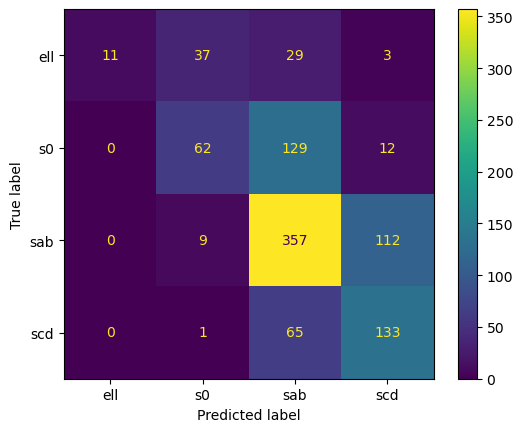

In [133]:
# Repeat on target
target_test_accuracy, target_test_loss, target_test_predictions, target_test_true = test_loop(target_test_dataloader, no_da_model, loss_fn)
print('Our baseline model accuracy and loss on the target data is', target_test_accuracy, target_test_loss)

# Reformate predictions to use in confusion matrix
target_test_predictions_array = np.array([])
target_test_true_array = np.array([])
for i in range(len(target_test_predictions)):
    batch_preds = target_test_predictions[i].numpy()
    batch_true = target_test_true[i].numpy()
    target_test_predictions_array = np.append(target_test_predictions_array, batch_preds)
    target_test_true_array = np.append(target_test_true_array, batch_true)
# Plot confusion matrix    
target_test_cm = confusion_matrix(target_test_true_array, target_test_predictions_array)
target_test_cm_plot = ConfusionMatrixDisplay(target_test_cm, display_labels=['ell', 's0', 'sab', 'scd'])
target_test_cm_plot.plot()

**It is still doing alright on the target data, but there is quite a lot of room to improve. It is struggling significantly with the s0 and ell galaxies, so we will see if the domain adaptation helps with this**

# While making this summary notebook, I don't have time to retrain the DANN (since it takes many hours) before the assignment is due, so I'm loading in a previously trained model. You can see the training for this model in the "DANN Network Testing" notebook. I am using the model saved after 180 epochs.

# Now with domain adaptation (DANN)

In [134]:
# Read in model
da_model = DANN().cuda()
da_model.load_state_dict(torch.load('C:/Users/paxso/galclass_da/code/networks/dann_trained.pt'))
# Load in the training stats (also from the original training notebook)
# Only look at the first 180 epoch, as the model I loaded was saved at the 180th epoch
dann_training_stats = np.load('C:/Users/paxso/galclass_da/code/networks/DANN_300epochs_stats.npy')[:, 0:180]
print(np.shape(dann_training_stats))

(13, 180)


Stats are in this format -  
        0 - source_estimate_training_accuracy   
        1 - source_estimate_training_loss   
        2 - source_domain_training_loss   
        3 - target_estimate_training_accuracy   
        4 - target_estimate_training_loss   
        5 - target_domain_training_loss  
        6 - source_estimate_val_accuracy   
        7 - source_estimate_val_loss   
        8 - source_domain_val_loss  
        9 - target_estimate_val_accuracy   
        10 - target_estimate_val_loss  
        11 - target_domain_val_loss  
        12 - dc_accuracy  

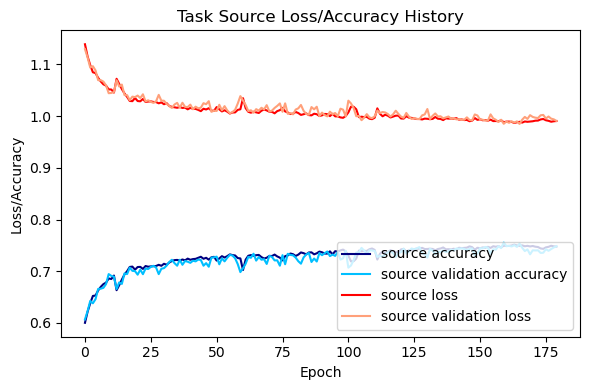

In [135]:
# Lets plot the estimator training history on source
epochs = list(range(len(dann_training_stats[0])))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, dann_training_stats[0], 'navy', label='source accuracy')
plot1_val_lacc = axis1.plot(epochs, dann_training_stats[6], 'deepskyblue', label="source validation accuracy")

plot1_loss = axis1.plot(epochs, dann_training_stats[1], 'red', label='source loss')
plot1_val_loss = axis1.plot(epochs, dann_training_stats[7], 'lightsalmon', label="source validation loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Task Source Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower right')

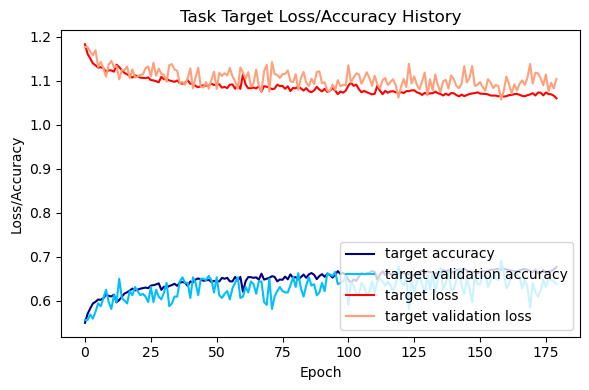

In [136]:
# Lets plot the estimator training history on target
epochs = list(range(len(dann_training_stats[0])))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, dann_training_stats[3], 'navy', label='target accuracy')
plot1_val_lacc = axis1.plot(epochs, dann_training_stats[9], 'deepskyblue', label="target validation accuracy")

plot1_loss = axis1.plot(epochs, dann_training_stats[4], 'red', label='target loss')
plot1_val_loss = axis1.plot(epochs, dann_training_stats[10], 'lightsalmon', label="target validation loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Task Target Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower right')

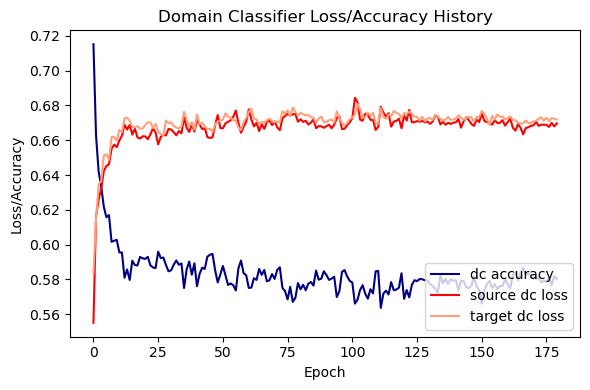

In [137]:
# Pot the domain classifier history
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, dann_training_stats[12], 'navy', label='dc accuracy')

plot1_loss = axis1.plot(epochs, dann_training_stats[2], 'red', label='source dc loss')
plot1_val_loss = axis1.plot(epochs, dann_training_stats[5], 'lightsalmon', label="target dc loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Domain Classifier Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower right')

**For a DANN, all of these look right. Both tasks have been maximized over time, while the accuracy of the domain classifier has been minimized over time**

Our DANN model accuracy and loss on the source data is 0.7479405444126075 0.9884780141548988


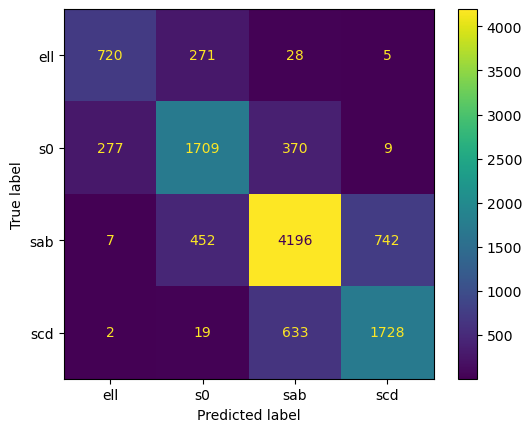

In [138]:
# Let's test the DANN model
# Test it on source
source_test_accuracy, source_test_loss, source_test_predictions, source_test_true = dann_test_loop(source_test_dataloader, da_model, loss_fn)
print('Our DANN model accuracy and loss on the source data is', source_test_accuracy, source_test_loss)

# Reformate predictions to use in confusion matrix
source_test_predictions_array = np.array([])
source_test_true_array = np.array([])
for i in range(len(source_test_predictions)):
    batch_preds = source_test_predictions[i].numpy()
    batch_true = source_test_true[i].numpy()
    source_test_predictions_array = np.append(source_test_predictions_array, batch_preds)
    source_test_true_array = np.append(source_test_true_array, batch_true)
# Plot confusion matrix    
source_test_cm = confusion_matrix(source_test_true_array, source_test_predictions_array)
source_test_cm_plot = ConfusionMatrixDisplay(source_test_cm, display_labels=['ell', 's0', 'sab', 'scd'])
source_test_cm_plot.plot()

**There is a few percent of accuracy lost on the source data, but the DANN is still overall performing well on it**

Our DANN model accuracy and loss on the target data is 0.640625 1.0901448468367259


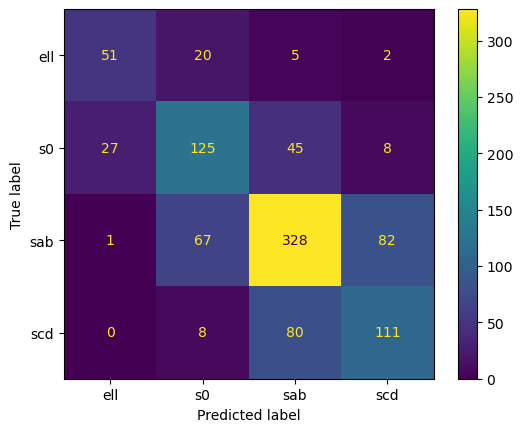

In [139]:
# Repeat on target
target_test_accuracy, target_test_loss, target_test_predictions, target_test_true = dann_test_loop(target_test_dataloader, da_model, loss_fn)
print('Our DANN model accuracy and loss on the target data is', target_test_accuracy, target_test_loss)

# Reformate predictions to use in confusion matrix
target_test_predictions_array = np.array([])
target_test_true_array = np.array([])
for i in range(len(target_test_predictions)):
    batch_preds = target_test_predictions[i].numpy()
    batch_true = target_test_true[i].numpy()
    target_test_predictions_array = np.append(target_test_predictions_array, batch_preds)
    target_test_true_array = np.append(target_test_true_array, batch_true)
# Plot confusion matrix    
target_test_cm = confusion_matrix(target_test_true_array, target_test_predictions_array)
target_test_cm_plot = ConfusionMatrixDisplay(target_test_cm, display_labels=['ell', 's0', 'sab', 'scd'])
target_test_cm_plot.plot()

**We don't have a ton of testing data, as to get good results I had to use most of the target data on training. That said, we have still gotten positive results. This is a 5% accuracy increase from no domain adaptation at all, without ever having access to the target data's labels during training.**

# Conclusion
**All of the techniques I implemented worked how they were supposed to. The baseline network with no domain adaptation got to near 80% accuracy on the sdss images, which is good for the complexity of the 4 class problem. It did not perform as well on the target data, though, getting only 59% accuracy. Using domain adaptation, it trained how it was supposed to. I maximized performance on the task with sdss images, while minimizing its ability to tell the difference between source and target data. This resulted in decently retained performance on the source data and a 5% increase in accuracy on the target data. While this isn't a huge jump, it does show that the techniques I implemented work. From here, better results may be attained through further tuning of model architecture and hyperparameters**